In [34]:
import numpy as np 
import csv
import matplotlib
import matplotlib.pyplot as plt
import os
from sklearn.linear_model import LinearRegression
from sklearn.preprocessing import MinMaxScaler
import pandas as pd
import torch
import torch.nn as nn
import torch.nn.functional as F
import torch.optim as optim
import time
from lib.nn import*
from lib.plot import *
import pickle
plt.rcParams['font.size'] = '18'
plt.rcParams["font.family"] = "Times New Roman"
torch.manual_seed(10)
np.random.seed(10)

path = "D:\\USC_google_drive\\DOE project\\Aveva_adaptive"
os.chdir(path)

data = np.genfromtxt('data/gen1.csv', delimiter=',')[1:,:]
data = data.astype(np.float32)
with open('data/gen1.csv', 'r') as infile:
    reader = csv.DictReader(infile)
    header= reader.fieldnames
header = [key for key in header]

datax = np.load('randomSample.npy')

dataypos = [0,12]
datay = data[:,dataypos]
data = np.hstack((datax,datay))
modelname0 = 'model4'
# modelname0 = 'modeltemp'
modelname =modelname0  +'.pt'
# Train = True
Train = False

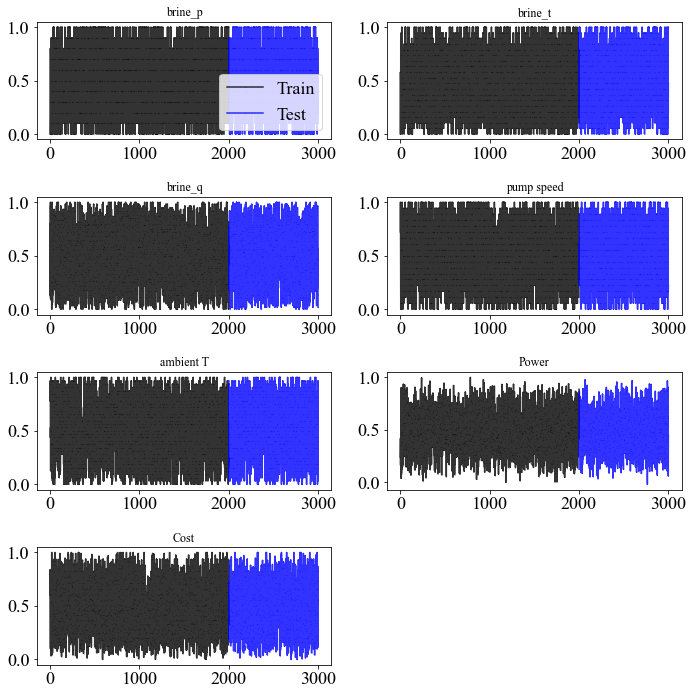

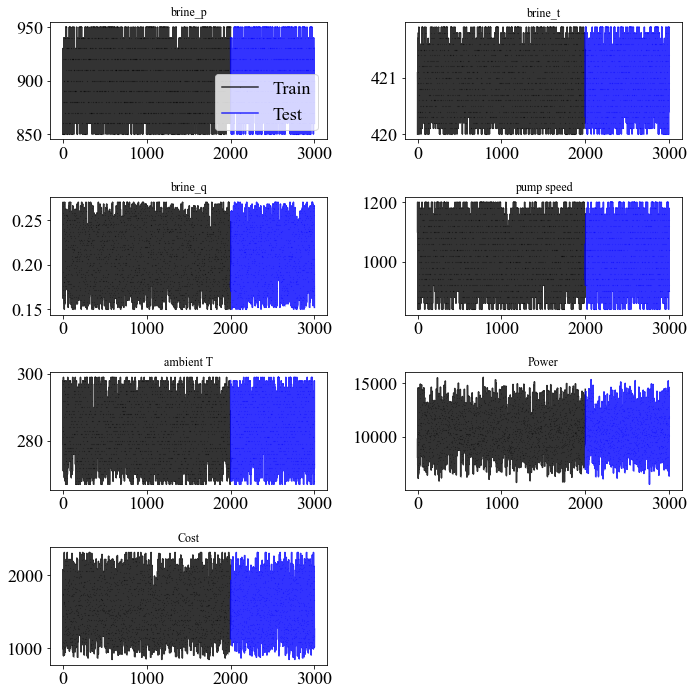

In [35]:
header1= header[:5]
header2= header[5:]

data = data[:3000,:]
# scaler = MinMaxScaler()
# scaler.fit(data)

import pickle
# pickle.dump(scaler, open('scaler2.pkl', 'wb'))
scaler = pickle.load(open('scaler2.pkl','rb'))

datan = scaler.transform(data)
datan = datan.astype(np.float32)
trainlen =2000
train = datan[:trainlen,:]
test = datan[trainlen:,:]

header = ['brine_p','brine_t','brine_q','pump speed','ambient T','Power','Cost']


def plot_data(data,  N_train, header):

    ncols = 2
    nrows = 4
    fig, axes = plt.subplots(nrows, ncols, figsize=(10, 10))
    axesf = axes.flatten()
    l = len(data)
    for j in range(data.shape[1]):
        if j < data.shape[1]:
            ax1 = axesf[j]
            ax1.plot(data[:N_train, j], color='black', marker='o', markersize=0.1, label='Train' , alpha=0.8)
            ax1.plot(range(N_train,l),data[N_train:,j], color='blue', marker='o', markersize=0.1, label='Test', alpha=0.8)          

            ax1.set_title(header[j], fontsize =12)
            if j ==0:
                ax1.legend(loc=0)
        else:
            break
    axesf[j+1].axis('off')
    plt.tight_layout()       

plot_data(datan[:,:],trainlen ,header)  
plot_data(data[:,:],trainlen ,header)  

In [36]:
# class Net(nn.Module):

#     def __init__(self):
#         super(Net, self).__init__()

#         self.fc1 = nn.Linear(5, 20)  # 5*5 from image dimension
#         self.fc2 = nn.Linear(20, 40)
#         self.fc3 = nn.Linear(40, 2)
# #         self.fc4 = nn.Linear(50, 5)
#     def forward(self, x):
#         x = F.relu(self.fc1(x))
#         x = F.relu(self.fc2(x))
#         x = self.fc3(x)
#         return x
net = Net()
print(net)

Net(
  (fc1): Linear(in_features=5, out_features=20, bias=True)
  (fc2): Linear(in_features=20, out_features=40, bias=True)
  (fc3): Linear(in_features=40, out_features=2, bias=True)
)


In [37]:

device = torch.device('cuda:0' if torch.cuda.is_available() else 'cpu')   # use GPU if available
net = Net().to(device)    # transfer model to GPU if available
net = net.train()   # set model in train mode (eg batchnorm params get updated)
if Train:
    opt = optim.Adam(net.parameters(), lr=0.005)       # create optimizer instance
    criterion = nn.MSELoss()    # create loss layer instance
#     criterion = nn.L1Loss()
    # criterion = nn.SmoothL1Loss()
    train_it = 0
    best_loss = 100
    batch_size = 16
    epochs = 150
    val_loss = []
    rec_loss = []
    vallen = int(trainlen*0.7)
    for ep in range(epochs):

        learning_rate = 0.01/(2*(ep//40+1))
    #     print(learning_rate)

        opt = optim.Adam(net.parameters(), lr=0.005)    
        # separate into training and test
        np.random.seed(int(time.time()))
        trainl = np.arange(len(train))
        np.random.shuffle(trainl)
    #     traintemp = train[trainl[:6000],:] 
    #     val = train[trainl[6000:],:] 
        int(trainlen*0.7)
        traintemp = train[trainl[:vallen],:] 
        val = train[trainl[vallen:],:] 
        val = torch.from_numpy(val)
        traintemp = torch.from_numpy(traintemp)
        print("Run Epoch {}".format(ep))

        Trains = torch.utils.data.DataLoader(traintemp,batch_size=batch_size)    

        for Train in Trains:
            train_x = Train[:,:5]
            train_y = Train[:,5:]
            opt.zero_grad()
            outputs = net(train_x)
            # loss
            total_loss = criterion(outputs, train_y)

            # backward
            total_loss.backward()
            # update the weights
            opt.step()

            if train_it % 1000 == 0:
                print("It {}: Reconstruction Loss: {}".format(train_it, total_loss))
            train_it += 1


        val_output = net(val[:,:5]) 
        val_loss1 = criterion(val_output,val[:,5:])
        val_loss.append(val_loss1)
        train_output = net(traintemp[:,:5])
        total_loss = criterion(train_output, traintemp[:,5:])
        rec_loss.append(total_loss)

        print("It {}: Validation Loss: {}".format(ep, val_loss1))
        if val_loss1 < best_loss:
            torch.save(net.state_dict(), './history/model_gen/'+modelname)
            best_loss = val_loss1

    print("Done!")

    plt.plot(rec_loss,label = 'train_loss')
    plt.plot(val_loss,label = 'val_loss')
    plt.title("Reconstruction Loss")
    plt.legend()
    plt.show

[0.018 0.018]
[0.022 0.028]


C:\Users\Wei_L\Anaconda3\lib\site-packages\ipykernel_launcher.py:23: RuntimeWarning: divide by zero encountered in true_divide


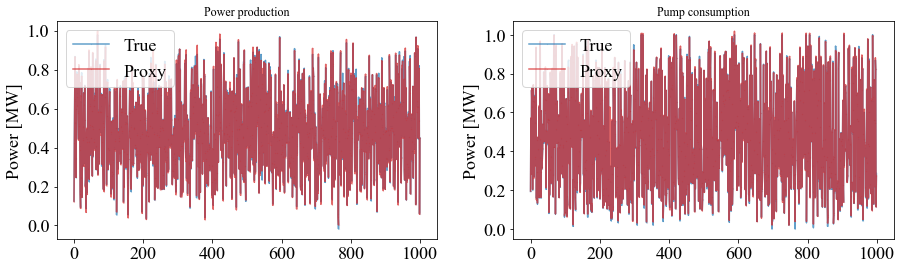

In [38]:
def plot_result(data1, data2, header):
    fig, ax1 = plt.subplots(1,2, figsize=(15,4))
    ax1[0].plot(data1[:,0], color='tab:blue', marker='o', markersize=0.1, label='True' , alpha=0.7)
    ax1[0].plot(data2[:,0], color='tab:red', marker='o', markersize=0.1, label='Proxy', alpha=0.7)          
    ax1[0].legend()
    ax1[0].set_title("Power production", fontsize =12)
    ax1[0].set_ylabel('Power [MW]')
#     plt.show()
    ax1[1].plot(data1[:,1], color='tab:blue', marker='o', markersize=0.1, label='True' , alpha=0.7)
    ax1[1].plot(data2[:,1], color='tab:red', marker='o', markersize=0.1, label='Proxy', alpha=0.7)          
    ax1[1].legend()
    ax1[1].set_title("Pump consumption", fontsize =12)
    ax1[1].set_ylabel('Power [MW]')
#     plt.show()

net = Net().to(device)
net.load_state_dict(torch.load('./history/model_gen/'+modelname))
net = net.eval() 
testx = torch.from_numpy(test[:,:5])
pred = net(testx).detach().numpy()
testy = test[:,5:]

temp = np.ma.masked_invalid(np.abs(pred-testy)/testy)
mse = np.round(np.sqrt(np.mean((pred- testy)**2,axis =0)),3)
mae = np.round(np.mean(temp,axis =0),3)


# testy = scaler.inverse_transform(test)[:,5:]
# pred = scaler.inverse_transform(np.hstack([test[:,:5],pred]))[:,5:]
print(mse)
print(mae)




plot_result(testy[:,],pred[:,],header2)

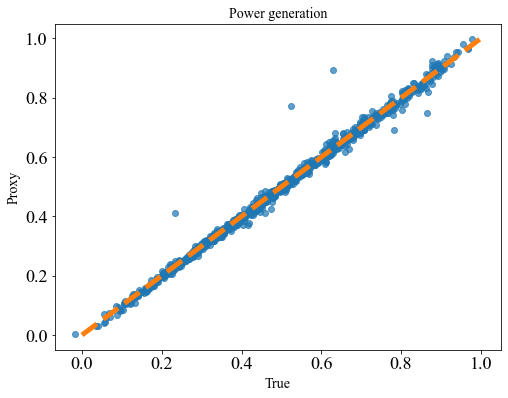

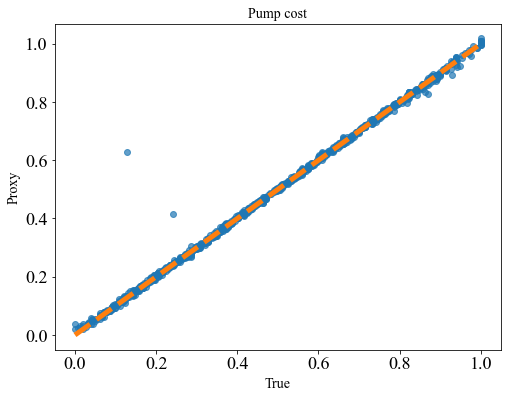

In [39]:
plt.figure(figsize = (8,6))
plt.scatter(testy[:,0],pred[:,0],alpha = 0.7)
plt.plot([0, 1], [0, 1], ls="--",linewidth = 5, color = 'tab:orange')

plt.xlabel('True',fontsize=14)
plt.ylabel('Proxy',fontsize=14)
plt.title('Power generation',fontsize = 14)
plt.savefig("./result/exp1-1.svg", bbox_inches='tight',dpi = 600)
plt.show()


plt.figure(figsize = (8,6))
plt.scatter(testy[:,1],pred[:,1],alpha = 0.7)
plt.plot([0, 1], [0, 1], ls="--",linewidth = 5, color = 'tab:orange')
plt.xlabel('True',fontsize=14)
plt.ylabel('Proxy',fontsize=14)
plt.title('Pump cost',fontsize = 14)
plt.savefig("./result/exp1-2.svg", bbox_inches='tight',dpi = 600)
plt.show()

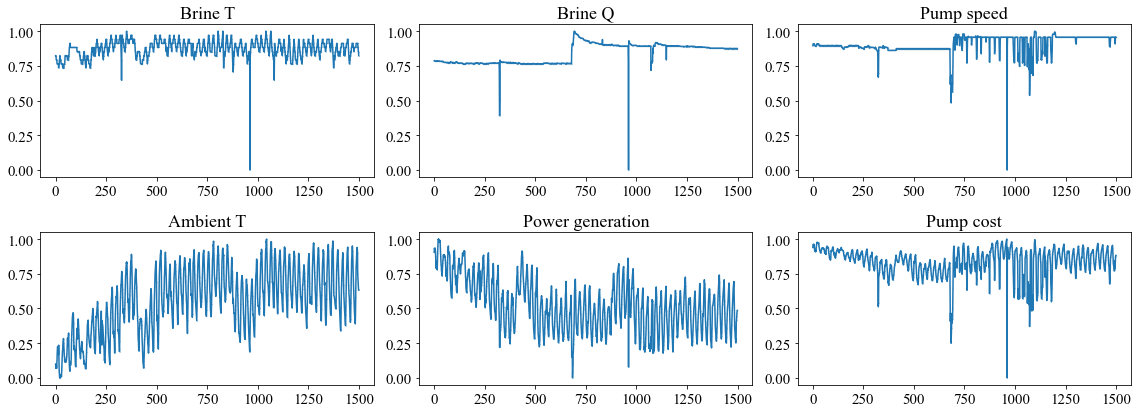

In [40]:
## to plot data 
plt.rcParams['font.size'] = '15'
plt.rcParams["font.family"] = "Times New Roman"
data = np.genfromtxt('data/longsimple1.csv', delimiter=',')[1:,:]
data = data.astype(np.float32)
with open('data/longsimple1.csv', 'r') as infile:
    reader = csv.DictReader(infile)
    header= reader.fieldnames
header = [key for key in header]

data[:,-1] = data[:,-2]- data[:,-1]
data = data[-1500:,:]
header1= header[:5]
header2= header[5:]
scaler2 = MinMaxScaler()
scaler2.fit(data)
test = scaler2.transform(data)
header[-1]= 'pump cost'

def plot_data(data,  N_train, header):

    ncols = 3
    nrows = 2
    fig, axes = plt.subplots(nrows, ncols, figsize=(16, 6))
    axesf = axes.flatten()
    l = len(data)
    for j in range(data.shape[1]):
        if j < data.shape[1]:
            ax1 = axesf[j]
            ax1.plot(data[:N_train, j], '.-', marker='o', markersize=0.1, label='Train' , alpha=1)
            

            ax1.set_title(header[j])

        else:
            break
    plt.tight_layout()
    
headerx = ['Brine T','Brine Q','Pump speed','Ambient T','Power generation','Pump cost']
plot_data(test[:,1:],1500 ,headerx[:])

[0.009 0.009]
[0.015 0.013]


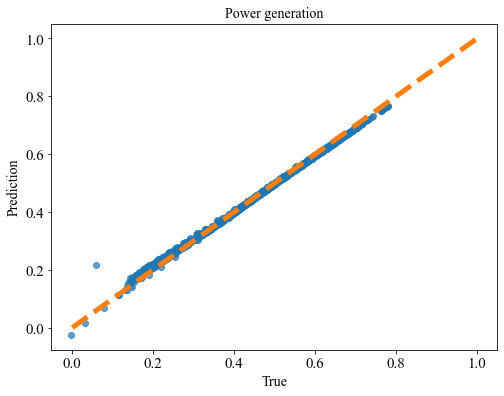

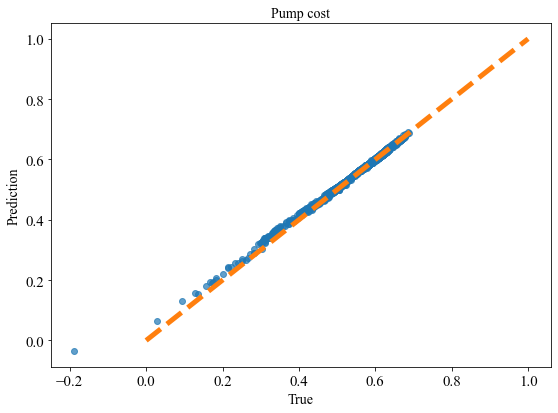

In [41]:
## 
data = np.genfromtxt('data/longsimple1.csv', delimiter=',')[1:,:]
data = data.astype(np.float32)
with open('data/longsimple1.csv', 'r') as infile:
    reader = csv.DictReader(infile)
    header= reader.fieldnames
header = [key for key in header]


header1= header[:5]
header2= header[5:]

# temp = (data[:,0]>850) & (data[:,0]<960)
# data = data[temp,:]

# temp = (data[:,1]>419.5) & (data[:,1]<422)
# data = data[temp,:]

# temp = (data[:,2]>0.17) 
# data = data[temp,:]

# temp = (data[:,3]>950) 
# data = data[temp,:]
data[:,-1] = data[:,-2]- data[:,-1]

data = data[-1500:,:]
test = scaler.transform(data)

# plot_data(test[:,:],1500 ,header) 
# plot_data(data[:,:],1500 ,header) 


net = Net().to(device)
net.load_state_dict(torch.load('./history/model_gen/'+modelname))
net = net.eval() 
testx = torch.from_numpy(test[:,:5])
pred = net(testx).detach().numpy()
testy = test[:,5:]

temp = np.ma.masked_invalid(np.abs(pred-testy)/testy)
mse = np.round(np.sqrt(np.mean((pred- testy)**2,axis =0)),3)
mae = np.round(np.mean(temp,axis =0),3)


# testy = scaler.inverse_transform(test)[:,5:]
# pred = scaler.inverse_transform(np.hstack([test[:,:5],pred]))[:,5:]
print(mse)
print(mae)


plt.figure(figsize = (8,6))
plt.scatter(testy[:,0],pred[:,0],alpha = 0.7)
plt.plot([0, 1], [0, 1], ls="--",linewidth = 5, color = 'tab:orange')

plt.xlabel('True',fontsize=14)
plt.ylabel('Prediction',fontsize=14)
plt.title('Power generation',fontsize = 14)
plt.savefig("./result/exp1-3.svg", bbox_inches='tight',dpi = 600)
plt.show()


plt.figure(figsize = (8,6))
plt.scatter(testy[:,1],pred[:,1],alpha = 0.7)
plt.plot([0, 1], [0, 1], ls="--",linewidth = 5, color = 'tab:orange')
plt.xlabel('True',fontsize=14)
plt.ylabel('Prediction',fontsize=14)
plt.title('Pump cost',fontsize = 14)
plt.tight_layout()

plt.savefig("./result/exp1-4.svg", bbox_inches='tight',dpi = 600)
plt.show()

testy = scaler.inverse_transform(test)[:,5:]
pred = scaler.inverse_transform(np.hstack([test[:,:5],pred]))[:,5:]

# for i in range(5):

#     plt.plot(testy[:,i])
#     plt.plot(pred[:,i])
#     plt.title(header2[i])
#     plt.show()

# plot_result(testy[:,],pred[:,],header2)



In [42]:
data.shape

(1500, 7)

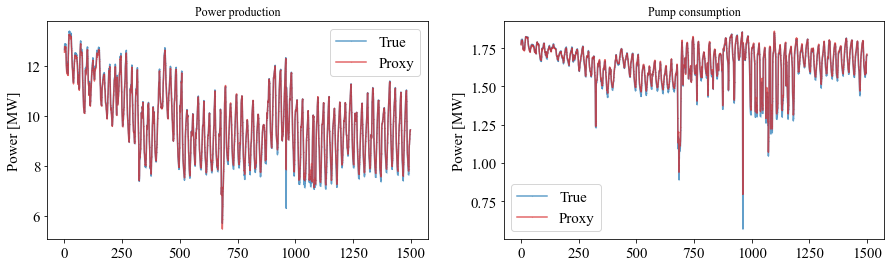

In [43]:
def plot_result(data1, data2, header):
    fig, ax1 = plt.subplots(1,2, figsize=(15,4))
    ax1[0].plot(data1[:,0]/1e3, color='tab:blue', marker='o', markersize=0.1, label='True' , alpha=0.7)
    ax1[0].plot(data2[:,0]/1e3, color='tab:red', marker='o', markersize=0.1, label='Proxy', alpha=0.7)          
    ax1[0].legend()
    ax1[0].set_title("Power production", fontsize =12)
    ax1[0].set_ylabel('Power [MW]')
#     plt.show()
    ax1[1].plot(data1[:,1]/1e3, color='tab:blue', marker='o', markersize=0.1, label='True' , alpha=0.7)
    ax1[1].plot(data2[:,1]/1e3, color='tab:red', marker='o', markersize=0.1, label='Proxy', alpha=0.7)          
    ax1[1].legend()
    ax1[1].set_title("Pump consumption", fontsize =12)
    ax1[1].set_ylabel('Power [MW]')
    fig.savefig("./result/exp1-5.svg", bbox_inches='tight',dpi = 600)
plot_result(testy[:,],pred[:,],header2)   

In [44]:
from scipy.optimize import minimize,Bounds,SR1, rosen, shgo
from scipy import optimize
from scipy.optimize import rosen, differential_evolution


net = Net()
net.load_state_dict(torch.load('./history/model_gen/'+modelname))
net = net.eval() 
tmp = scaler.data_max_-scaler.data_min_

class MPC():
    def __init__(self, inputs,step):
        self.x = inputs.clone()
        self.step = step
        self.xlist = []
        self.outlist = []
    def renew(self,i):
        self.iter  = i 
        self.inputs = self.x[i:i+step,:]
#         print(self.inputs.shape)
    def objfun(self,x):
        x = np.tile(x, (step,1))
        a = torch.tensor(x)
 
        a = torch.from_numpy(x).float() 
        input_tmp = self.inputs
#         print(input_tmp.shape)
#         print(a.shape)
        input_tmp[:,3] = a[:,0]
        net = Net()
        net.load_state_dict(torch.load('./history/model_gen/'+modelname))
        net = net.eval() 

        result = net(input_tmp)
        result = (result[:,1]*tmp[6]+
                scaler.data_min_[6])-(result[:,0]*tmp[5]+scaler.data_min_[5])
        result = sum(result)
#         print(result)
        return np.sum(result.detach().numpy())

    def objfunnew(self,x):
        x = np.tile(x, (step,1))
        a = torch.tensor(x)

        a = torch.from_numpy(x).float() 
        input_tmp = self.inputs
#         print(input_tmp.shape)
#         print(a.shape)
        input_tmp[:,3] = a[:,0]
        net = Net()
        net.load_state_dict(torch.load('./history/model_gen/'+modelname))
        net = net.eval() 

        result = net(input_tmp)
        result = (result[:,1]*tmp[6]+
                scaler.data_min_[6])-(result[:,0]*tmp[5]+scaler.data_min_[5])
        result = sum(result)
#         print(result)

        self.xlist = [x]
        self.outlist.append(np.sum(result.detach().numpy()))
        return np.sum(result.detach().numpy())
step = 1

bounds = [[0,1]]
cons = []
for factor in range(len(bounds)):
    lower, upper = bounds[factor]
    l = {'type': 'ineq',
         'fun': lambda x, lb=lower, i=factor: x[i] - lb}
    u = {'type': 'ineq',
         'fun': lambda x, ub=upper, i=factor: ub - x[i]}
    cons.append(l)
    cons.append(u)
# cons = [(0,1)]
b = [(0,1)] 
testx = torch.from_numpy(np.copy(test[:,:5]))
x = testx[:,[3]].detach().numpy()
mpc = MPC(testx,step)
result = []

lentest = len(test)

for i in range(lentest//step):
    mpc.renew(i*step)
    x0 = [testx[i,3]] 
#     res = minimize(mpc.objfun, x0, constraints=cons,method='COBYLA')
    res = minimize(mpc.objfun, x0,bounds=b,options={'ftol': 1e-6,'eps':1e-6})
#     res = minimize(mpc.objfun, x0, jac = '3-points',bounds=b,callback = callback,method='SLSQP' ,options={'eps':0.001})
    print(i)
    print(res.x)
#     for i in range(step):
    result.extend([res.x[0]]*step)

0
[0.68055552]
1
[1.]
2
[1.]
3
[1.]
4
[0.69722217]
5
[1.]
6
[1.]
7
[1.]
8
[1.]
9
[0.68055552]
10
[0.68055552]
11
[0.68055552]
12
[0.68055552]
13
[1.]
14
[1.]
15
[1.]
16
[0.68055552]
17
[0.68055552]
18
[1.]
19
[0.68888897]
20
[0.69722217]
21
[0.69722217]
22
[0.69722217]
23
[1.]
24
[1.]
25
[1.]
26
[0.69722217]
27
[1.]
28
[1.]
29
[1.]
30
[1.]
31
[0.68055552]
32
[0.68055552]
33
[0.68055552]
34
[0.68055552]
35
[1.]
36
[0.68055552]
37
[1.]
38
[1.]
39
[1.]
40
[1.]
41
[0.68055552]
42
[1.]
43
[1.]
44
[1.]
45
[0.68055552]
46
[0.68055552]
47
[1.]
48
[1.]
49
[0.68055552]
50
[1.]
51
[1.]
52
[0.68055552]
53
[1.]
54
[0.67777771]
55
[0.68055552]
56
[1.]
57
[0.68055552]
58
[0.68055552]
59
[0.68055552]
60
[0.68055552]
61
[0.68055552]
62
[1.]
63
[1.]
64
[1.]
65
[0.68055419]
66
[1.]
67
[0.68055552]
68
[0.68055552]
69
[0.68055552]
70
[0.68055552]
71
[0.68055552]
72
[1.]
73
[1.]
74
[1.]
75
[0.68333334]
76
[0.68055552]
77
[1.]
78
[0.68055552]
79
[0.68055496]
80
[1.]
81
[1.]
82
[0.68055552]
83
[0.68055552]
84

611
[1.]
612
[0.65277785]
613
[0.65277785]
614
[1.]
615
[1.]
616
[1.]
617
[0.65277785]
618
[1.]
619
[0.65277742]
620
[0.65277785]
621
[1.]
622
[0.47170159]
623
[0.6430331]
624
[0.62959771]
625
[1.]
626
[0.65277785]
627
[1.]
628
[0.6052826]
629
[0.65277785]
630
[0.62155082]
631
[0.65277785]
632
[1.]
633
[0.65277785]
634
[0.65277785]
635
[0.65277785]
636
[0.65277785]
637
[0.65277785]
638
[0.65277785]
639
[1.]
640
[0.65277785]
641
[1.]
642
[0.65277758]
643
[0.65277785]
644
[1.]
645
[1.]
646
[0.62347333]
647
[0.62334537]
648
[0.63103568]
649
[1.]
650
[1.]
651
[0.59390088]
652
[0.65277785]
653
[1.]
654
[0.56648422]
655
[1.]
656
[0.65277785]
657
[1.]
658
[0.65277785]
659
[1.]
660
[1.]
661
[1.]
662
[0.65277785]
663
[1.]
664
[0.65277785]
665
[1.]
666
[1.]
667
[1.]
668
[0.65277785]
669
[0.56724739]
670
[0.54538073]
671
[0.62790222]
672
[0.62570813]
673
[1.]
674
[0.62092068]
675
[1.]
676
[0.5944158]
677
[0.65277785]
678
[0.5730953]
679
[1.]
680
[1.]
681
[1.]
682
[1.]
683
[1.]
684
[1.]
685
[1.]
6

1229
[1.]
1230
[0.75833338]
1231
[0.75833338]
1232
[0.73048935]
1233
[0.75833338]
1234
[0.65263357]
1235
[0.75833338]
1236
[0.75833338]
1237
[0.75833338]
1238
[1.]
1239
[0.75833338]
1240
[0.75833338]
1241
[1.]
1242
[1.]
1243
[1.]
1244
[1.]
1245
[0.75833338]
1246
[0.73057528]
1247
[0.69768794]
1248
[0.71688464]
1249
[0.75833338]
1250
[1.]
1251
[0.75466727]
1252
[1.]
1253
[0.75833338]
1254
[0.75833338]
1255
[1.]
1256
[1.]
1257
[1.]
1258
[0.66814745]
1259
[0.75833338]
1260
[0.7107833]
1261
[1.]
1262
[0.70981715]
1263
[0.75833338]
1264
[1.]
1265
[0.75833338]
1266
[0.75833338]
1267
[0.75833338]
1268
[0.75833338]
1269
[1.]
1270
[0.719749]
1271
[0.75833338]
1272
[0.75163541]
1273
[0.75833338]
1274
[1.]
1275
[1.]
1276
[1.]
1277
[1.]
1278
[1.]
1279
[0.75833338]
1280
[1.]
1281
[0.73365293]
1282
[0.73809649]
1283
[0.75833338]
1284
[0.62672401]
1285
[0.75833338]
1286
[1.]
1287
[0.71109052]
1288
[0.66209788]
1289
[0.75833338]
1290
[0.75833338]
1291
[0.75833338]
1292
[1.]
1293
[0.57938666]
1294
[1.]

In [48]:
result = np.array(result)
resultout = result*(scaler.data_max_[3] - scaler.data_min_[3])+scaler.data_min_[3] 
resultout2 = testx[:,3]*(scaler.data_max_[3] - scaler.data_min_[3])+scaler.data_min_[3] 

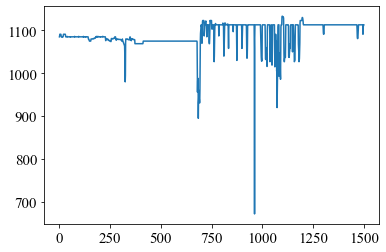

In [49]:
plt.plot(resultout2)

In [ ]:
# dataval2 = np.genfromtxt('globalopt_0304.csv', delimiter=',')[1:,:]
# with open('globalopt_0304.csv', 'r') as infile:
#     reader = csv.DictReader(infile)
#     header2= reader.fieldnames
# header2 = [key for key in header2]

# pos = [0,12]
# data2 = dataval2[:,pos]
# plot_result3(testy,data2,header2,'./fig/'+str(1)+'_optpred')

# result = np.array(result).reshape([-1,1])
# testx = torch.from_numpy(test[:,:5])
# # plt.plot(x[:,0])
# plt.plot(testx[:,3])
# plt.plot(result[:,0],alpha = 0.9)
# plt.title('pump')
# plt.show()


# resultout = result*(scaler.data_max_[3] - scaler.data_min_[3])+scaler.data_min_[3] 
# resultout2 = testx[:,3]*(scaler.data_max_[3] - scaler.data_min_[3])+scaler.data_min_[3] 

# ilist = [0,499,999,1499]

# plt.figure(figsize = (8,4))
# plt.plot(resultout2,alpha = 0.9,label = 'Orignal')
# plt.plot(resultout[:,0],alpha = 0.8,label = 'Optimized by ANN')
# plt.plot(dataval2[:,-1],alpha = 0.9,color = 'tab:red',label = 'Optimized by SIM')

# #hightlight points
# for i in ilist:
#     plt.plot(i+1,resultout[i,0],'bv',markersize=8)
    


# plt.title('Pump speed', fontsize)
# plt.legend()

# plt.savefig("./result/exp1-pump.svg", bbox_inches='tight',dpi = 600)

# plt.show()
# np.save('control'+modelname0, resultout)

# plt.figure(figsize = (8,4))
# plt.plot(data[:,4],alpha = 0.9,label = 'Orignal')
# plt.title('Ambient Temp')
# for i in ilist:
#     plt.plot(i+1,data[i,4],'rv',markersize=8)

# plt.savefig("./result/exp1-amb.svg", bbox_inches='tight',dpi = 600)
# plt.show()

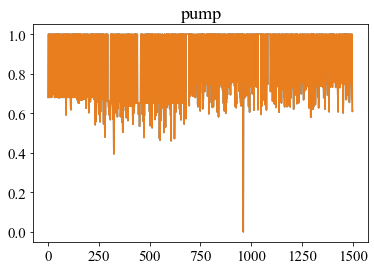

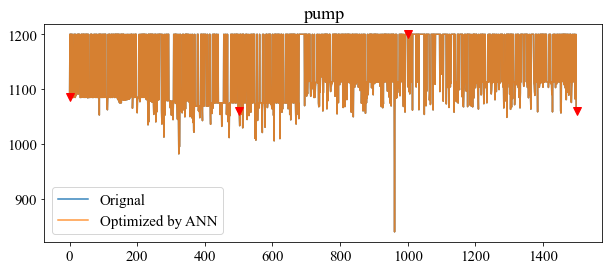

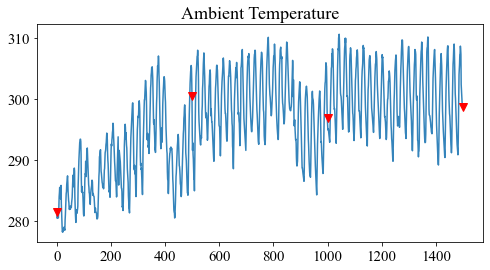

In [57]:
result = np.array(result).reshape([-1,1])
testx = torch.from_numpy(test[:,:5])
# plt.plot(x[:,0])
plt.plot(testx[:,3])
plt.plot(result[:,0],alpha = 0.9)
plt.title('pump')
plt.show()


resultout = result*(scaler.data_max_[3] - scaler.data_min_[3])+scaler.data_min_[3] 
resultout2 = testx[:,3]*(scaler.data_max_[3] - scaler.data_min_[3])+scaler.data_min_[3] 

ilist = [0,499,999,1499]

plt.figure(figsize = (10,4))
plt.plot(resultout2,alpha = 0.9,label = 'Orignal')
plt.plot(resultout[:,0],alpha = 0.8,label = 'Optimized by ANN')

#hightlight points
for i in ilist:
    plt.plot(i+1,resultout[i,0],'rv',markersize=8)
    


plt.title('pump')
plt.legend()

plt.savefig("./result/exp1-pump.svg", bbox_inches='tight',dpi = 600)

plt.show()
np.save('control'+modelname0, resultout)

plt.figure(figsize = (8,4))
plt.plot(data[:,4],alpha = 0.9,label = 'Orignal')
plt.title('Ambient Temperature')
for i in ilist:
    plt.plot(i+1,data[i,4],'rv',markersize=8)

plt.savefig("./result/exp1-amb.svg", bbox_inches='tight',dpi = 600)
plt.show()

[array(0.65277785, dtype=float32)]
[[array(0.65277785, dtype=float32)], array([1.]), array([1.])]
[1.]


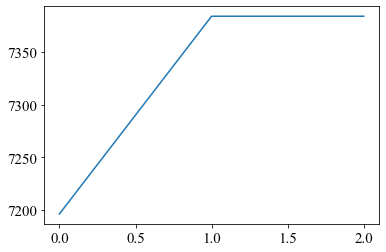

In [51]:
ii =499
mpc.renew(ii)
# x0 = [0]
x0 = [(testx[ii,3]).detach().numpy()]

history = [x0]
hisp = [mpc.objfun(x0)]
def callback(x):
    hisp.append(mpc.objfun(x))
    history.append(x)
print(x0)
res = minimize(mpc.objfun, x0,bounds=b, callback = callback,options={'ftol': 1e-8,'eps':1e-3})
# res = minimize(mpc.objfunnew, x0,constraints=cons,method='COBYLA')
# res = minimize(mpc.objfun, x0, jac = '2 points',bounds=b, callback = callback, method='SLSQP' ,options={'ftol': 1e-6,'eps':1e-6})
# res = minimize(mpc.objfun, x0,bounds=b, callback = callback, method='SLSQP' ,options={'ftol': 1e-6,'eps':1e-5})

# res = minimize(mpc.objfun, x0, method='trust-constr', hess=None,
#                bounds=b,  tol=None,
#                        options={'xtol': 1e-06, 'gtol': 1e-3,
#                                 'barrier_tol': 1e-4, 'sparse_jacobian': None,
#                                 'maxiter': 1e3, 'verbose': 2, 'finite_diff_rel_step': None,
#                                 'initial_constr_penalty': 0.1,
#                                 'initial_tr_radius': 0.1,
#                                 'initial_barrier_parameter': 0.1,
#                                 'initial_barrier_tolerance': 0.1,
#                                 'factorization_method': None, 'disp': True})
                                                                                                                
history.append(res.x)
hisp.append(res.fun)
print(history)
plt.plot(-np.array(hisp))
# plt.plot(hisp*(-1))
print(res.x)
# res.f

history = np.array(history)*(scaler.data_max_[3] - scaler.data_min_[3])+scaler.data_min_[3] 
np.save('valcontrol'+str(ii),history)

np.save('prxcontrol'+str(ii),-np.array(hisp))

In [ ]:
history

In [73]:
axs.flatten()

array([<AxesSubplot:>, <AxesSubplot:>, <AxesSubplot:>, <AxesSubplot:>],
      dtype=object)

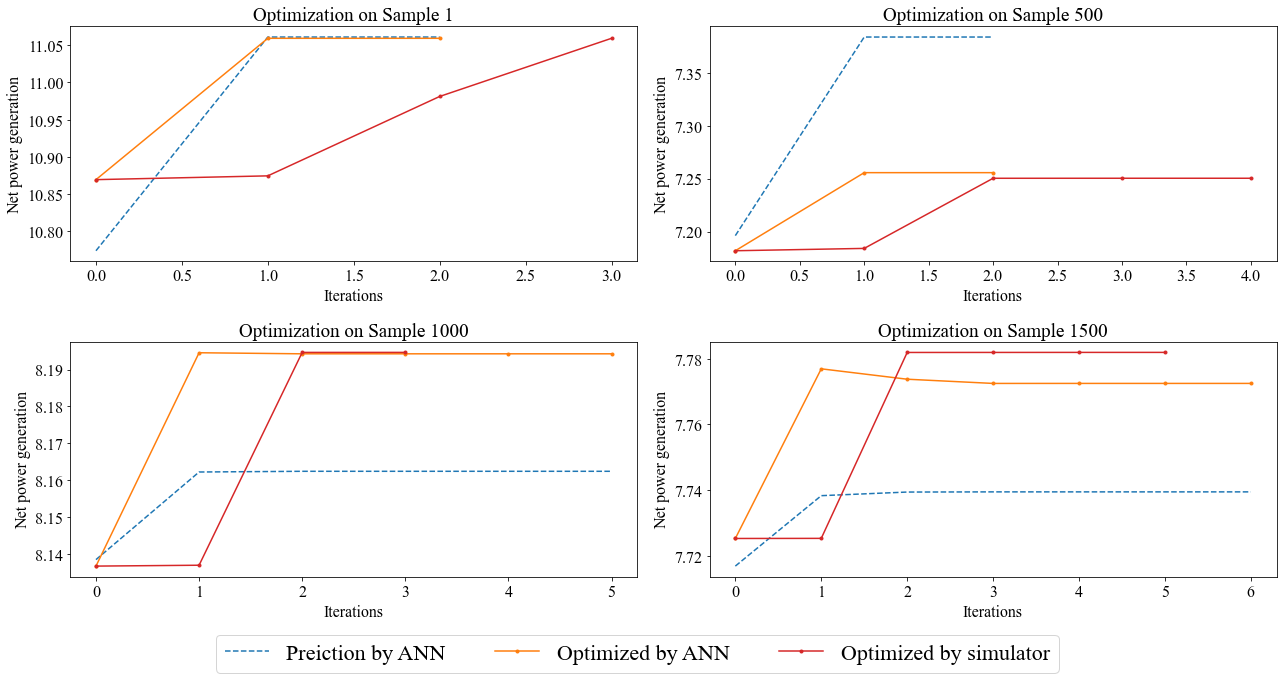

In [94]:
plt.rcParams['font.size'] = '16'
ii_list= [0,499,999,1499]
fig, axes = plt.subplots(2,2, figsize = [18,9])
axs = axes.flatten()
for i in range(4):
    ii = ii_list[i]
    history1 = np.load('prxcontrol'+str(ii)+'.npy')
    history2 = np.load('valAVEVA'+str(ii)+'.npy')[:,-3]
    history3 = np.load('optAVEVA'+str(ii)+'.npy')
#     from matplotlib.ticker import MaxNLocator
    axs[i].plot(history1/1e3,'--',color = "tab:blue",label = 'Preiction by ANN ')
    axs[i].plot(history2/1e3,'.-',color =  "tab:orange",label = 'Optimized by ANN ')
    axs[i].plot(history3/1e3,'.-',color =  "tab:red",label = 'Optimized by simulator')
    axs[i].set_xlabel('Iterations')
    axs[i].set_ylabel('Net power generation')
    axs[i].set_title('Optimization on Sample '+str(ii+1))
plt.tight_layout()
axs.flatten()[-2].legend(loc='upper center', bbox_to_anchor=(1, -0.2), ncol=3,fontsize = 22)

#     axs[i].legend()

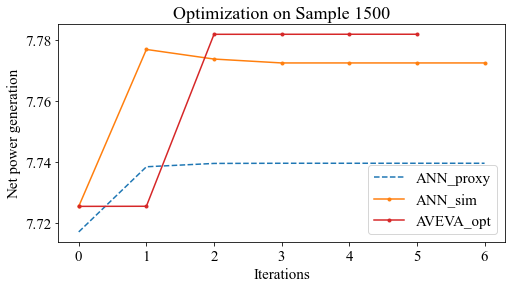

In [56]:
ii= 1499

history1 = np.load('prxcontrol'+str(ii)+'.npy')
history2 = np.load('valAVEVA'+str(ii)+'.npy')[:,-3]
history3 = np.load('optAVEVA'+str(ii)+'.npy')
from matplotlib.ticker import MaxNLocator

ax = plt.figure(figsize = (8,4)).gca()
ax.xaxis.set_major_locator(MaxNLocator(integer=True))


plt.plot(history1/1e3,'--',color = "tab:blue",label = 'Preiction by ANN ')
plt.plot(history2/1e3,'.-',color =  "tab:orange",label = 'Optimized by ANN ')
plt.plot(history3/1e3,'.-',color =  "tab:red",label = 'Optimized by simulator')
plt.xlabel('Iterations')
plt.ylabel('Net power generation')
plt.title('Optimization on Sample '+str(ii+1))
plt.legend()
plt.savefig("./result/exp1"+str(ii+1)+".svg", bbox_inches='tight',dpi = 600)




In [ ]:
# def plot_result2(data1, data2, header):
#     fig, ax1 = plt.subplots(1,3, figsize=(20,4))
#     ax1[0].plot(data1[:,0]/1e3, color='tab:blue', marker='o', markersize=0.1, label='True' , alpha=0.7)
#     ax1[0].plot(data2[:,0]/1e3, color='tab:red', marker='o', markersize=0.1, label='Optimized', alpha=0.7)          
#     ax1[0].legend()
#     ax1[0].set_title("Power production", fontsize =12)
#     ax1[0].set_ylabel('Power [MW]')
# #     plt.show()
#     ax1[1].plot(data1[:,1]/1e3, color='tab:blue', marker='o', markersize=0.1, label='True' , alpha=0.7)
#     ax1[1].plot(data2[:,1]/1e3, color='tab:red', marker='o', markersize=0.1, label='Optimized', alpha=0.7)          
#     ax1[1].legend()
#     ax1[1].set_title("Pump consumption", fontsize =12)
#     ax1[1].set_ylabel('Power [MW]')
    
#     ax1[2].plot(data1[:,0]/1e3-data1[:,1]/1e3, color='tab:blue', marker='o', markersize=0.1, label='True' , alpha=0.7)
#     ax1[2].plot(data2[:,0]/1e3-data2[:,1]/1e3, color='tab:red', marker='o', markersize=0.1, label='Optimized', alpha=0.7)          
#     ax1[2].legend()
#     ax1[2].set_title("Net", fontsize =12)
#     ax1[2].set_ylabel('Power [MW]')

In [53]:
net = Net()
net.load_state_dict(torch.load('./history/model_gen/'+modelname))
net = net.eval() 
test = test[:len(result),:]
test[:,3] = result[:,0] 
# test[:,4] = result[:,1]
testx = torch.from_numpy(test[:,:5])
 
pred = net(testx).detach().numpy()
testy = test[:,5:]
mse = np.round(np.sqrt(np.mean((pred- testy)**2,axis =0)),3)
testy_ = scaler.inverse_transform(test)[:,5:]
pred = scaler.inverse_transform(np.hstack([test[:,:5],pred]))[:,5:]
print(mse)
# for i in range(5):

#     plt.plot(testy[:,i])
#     plt.plot(pred[:,i])
#     plt.title(header2[i])
#     plt.show()
# plot_result2(testy_,pred,header2)

np.save('pred_by_model', pred)

print(np.mean(testy_[:,0]), np.mean(pred[:,0]))
print(np.mean(testy_[:,1]), np.mean(pred[:,1]))

print(np.mean(testy_[:,0]-testy_[:,1]), np.mean(pred[:,0]-pred[:,1]))

print((np.mean(pred[:,0]-pred[:,1]))/np.mean(testy_[:,0]-testy_[:,1]))

[0.053 0.213]
9738.034 10037.368
1641.9397 1823.2222
8096.0947 8214.1455
1.0145812


In [ ]:
plot_result3(testy_,pred,header2,'./fig/'+str(1)+'_optpred')

In [54]:
dataval = np.genfromtxt('ANNopt2.csv', delimiter=',')[1:,:]
with open('ANNopt2.csv', 'r') as infile:
    reader = csv.DictReader(infile)
    header2= reader.fieldnames
header2 = [key for key in header2]
pos = [0,12]
data3 = dataval[:,pos]
plot_result3(testy_,data2,header2,'./fig/'+str(1)+'_optpred')

NameError: name 'data2' is not defined

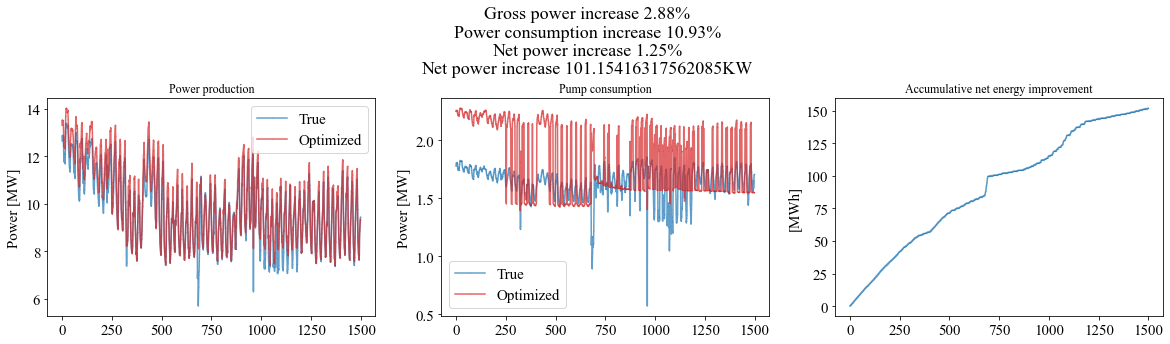

In [55]:
dataval2 = np.genfromtxt('globalopt_0304.csv', delimiter=',')[1:,:]
with open('globalopt_0304.csv', 'r') as infile:
    reader = csv.DictReader(infile)
    header2= reader.fieldnames
header2 = [key for key in header2]

pos = [0,12]
data2 = dataval2[:,pos]
plot_result3(testy_,data2,header2,'./fig/'+str(1)+'_optpred')

In [ ]:
def get_accumulate(data1,data2):
    temp = -data1[:,0]+data2[:,0]+data1[:,1]-data2[:,1]
    temp2 = np.add.accumulate(temp)/1e3
    return temp2
c1 = get_accumulate(testy_,data2)
c2 = get_accumulate(testy_,data3)

plt.figure(figsize = (8,4))
plt.plot(c1,'--',color = 'tab:blue', linewidth = 4,alpha = 1)
plt.plot(c2,'--',color = 'tab:orange', linewidth = 4,alpha = 1)
plt.fill_between(np.arange(1500),c1,c2, alpha = 0.8,label = 'Physics improved')
plt.fill_between(np.arange(1500),c2, alpha =.8, label = 'ANN improved')
plt.legend(loc='upper left', fontsize =13)
plt.xlabel('Hour')
plt.ylabel('Energy [MWh]')
plt.title("Accumulative net energy improvement", fontsize =13)
plt.savefig("./result/exp1-final.svg", bbox_inches='tight',dpi = 600)

In [ ]:
print(c1[-1])
print(c2[-1])

In [ ]:
bar1 = (np.mean(testy_,axis = 0)/1e3).tolist()
bar2 = (np.mean(data2,axis = 0)/1e3).tolist()
bar3 = (np.mean(data3,axis = 0)/1e3).tolist()
bar1.append(bar1[0]-bar1[1])
bar2.append(bar2[0]-bar2[1])
bar3.append(bar3[0]-bar3[1])

# bar1 = [np.mean(testy[:,0])/1e3,np.mean(data2[:,0])/1e3,np.mean(data3[:,0])/1e3]

# bar2 = [np.mean(testy[:,1])/1e3,np.mean(data2[:,1])/1e3,np.mean(data3[:,1])/1e3]
# bar3 = [(np.mean(testy[:,0])-np.mean(testy[:,1]))/1e3,data2[:,0]/1e3,data3[:,0]]

def addlabels(x,y,k):
    for i in range(len(x)):
        plt.text(i+k,y[i]+0.07,round(y[i],2),weight = 'bold')


barWidth = 0.3
# Set position of bar on X axis
r1 = np.arange(len(bar1))
r2 = [x + barWidth for x in r1]
r3 = [x + barWidth for x in r2]
 
# Make the plot
plt.figure(figsize = (8,4))
plt.bar(r1, bar1, color='tab:green', width=barWidth, edgecolor='black', label='Original')
addlabels(r1,bar1,-0.08)

plt.bar(r2, bar2, color='tab:blue', width=barWidth, edgecolor='black', label='Physics-opt')
addlabels(r2,bar2,0.2)
plt.bar(r3, bar3, color='tab:orange', width=barWidth, edgecolor='black', label='ANN-opt')
addlabels(r3,bar3,0.5) 
    
# Add xticks on the middle of the group bars
# plt.xlabel('group', fontweight='bold')
plt.xticks([r + barWidth for r in range(len(bar1))], ['Gross', 'Consume', 'Net'])
plt.ylabel('Mw')
plt.title('Average result of optimization')
# Create legend & Show graphic
plt.legend()

In [ ]:
bar1

In [ ]:
bd1 = np.mean(testy,axis = 0)
bd1

In [ ]:
plt.plot(resultout[:,0],alpha = 0.8,label = 'Optimized by ANN')

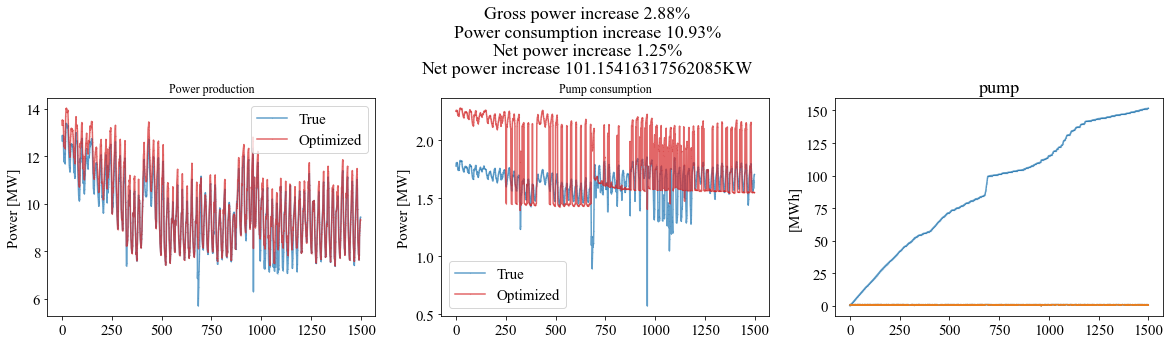

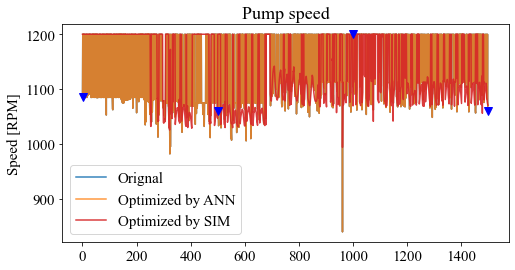

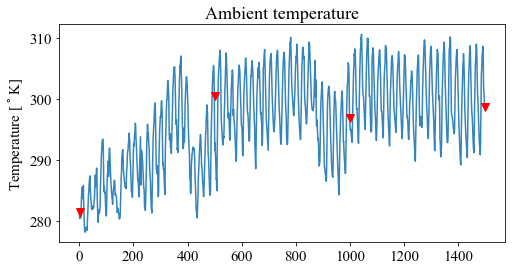

In [63]:
dataval2 = np.genfromtxt('globalopt_0304.csv', delimiter=',')[1:,:]
with open('globalopt_0304.csv', 'r') as infile:
    reader = csv.DictReader(infile)
    header2= reader.fieldnames
header2 = [key for key in header2]

pos = [0,12]
data2 = dataval2[:,pos]
plot_result3(testy_,data2,header2,'./fig/'+str(1)+'_optpred')

result = np.array(result).reshape([-1,1])
testx = torch.from_numpy(test[:,:5])
# plt.plot(x[:,0])
plt.plot(testx[:,3])
plt.plot(result[:,0],alpha = 0.9)
plt.title('pump')
plt.show()


resultout = result*(scaler.data_max_[3] - scaler.data_min_[3])+scaler.data_min_[3] 
resultout2 = testx[:,3]*(scaler.data_max_[3] - scaler.data_min_[3])+scaler.data_min_[3] 

ilist = [0,499,999,1499]

plt.figure(figsize = (8,4))
plt.plot(resultout2,alpha = 0.9,label = 'Orignal')
plt.plot(resultout[:,0],alpha = 0.8,label = 'Optimized by ANN')
plt.plot(dataval2[:,-1],alpha = 0.9,color = 'tab:red',label = 'Optimized by SIM')

#hightlight points
for i in ilist:
    plt.plot(i+1,resultout[i,0],'bv',markersize=8)
    


plt.title('Pump speed')
plt.legend()
plt.ylabel('Speed [RPM]')

plt.savefig("./result/exp1-pump.svg", bbox_inches='tight',dpi = 600)

plt.show()
np.save('control'+modelname0, resultout)

plt.figure(figsize = (8,4))
plt.plot(data[:,4],alpha = 0.9,label = 'Orignal')
plt.ylabel('Temperature [$^\circ$K]')
plt.title('Ambient temperature')
for i in ilist:
    plt.plot(i+1,data[i,4],'rv',markersize=8)

plt.savefig("./result/exp1-amb.svg", bbox_inches='tight',dpi = 600)
plt.show()